**PRACTICAL 09 | DEEP LEARNING**

MONISHA DEHANKAR | 06

**Language Identification With RNN**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # Deep learning framework
import torch.nn.functional as F
import time
import os

In [ ]:
#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

In [ ]:
# Any results you write to the current directory are saved as output.
raw = pd.read_csv('/content/dataset.csv')
x_train_full = raw['Text']
y_train_full = raw['language']
print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

Example:
LANG = Estonian
TEXT = klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke  aastal viidi ta surnukeha mausoleumist ära ja kremeeriti zlíni linn kandis aastatel – nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel – nime gotvald


In [ ]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [ ]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(x_train_full))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 7188 UTF characters
Labels: 22 languages


In [ ]:
#From token or label to index
print('k ->', char_vocab.token2idx['k'])
print('Estonian ->', lang_vocab.token2idx['Estonian'])
print(y_train_full[0], x_train_full[0][:10])
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])
print(y_train_idx[0], x_train_idx[0][:10])

k -> 26
Estonian -> 4
Estonian klement go
4 [26 27 20 28 20 29 35  2 22 30]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.2, random_state=42)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

17600 training samples
4400 validation samples


In [ ]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [ ]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [ ]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [ ]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [ ]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      # Gradient clipping https://www.kaggle.com/c/wili4/discussion/231378
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1

    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [ ]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [ ]:
hidden_size = 256
embedding_size = 64
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

In [ ]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [ ]:
batch_size, token_size = 256, 200000
epochs = 25
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 25 epochs
Train: wpb=88383, bsz=247, num_updates=71
| epoch 001 | train accuracy=54.8% (10s)
| epoch 001 | valid accuracy=78.0%
| epoch 002 | train accuracy=85.5% (20s)
| epoch 002 | valid accuracy=88.3%
| epoch 003 | train accuracy=93.3% (30s)
| epoch 003 | valid accuracy=93.2%
| epoch 004 | train accuracy=94.8% (41s)
| epoch 004 | valid accuracy=95.1%
| epoch 005 | train accuracy=96.0% (51s)
| epoch 005 | valid accuracy=95.9%
| epoch 006 | train accuracy=96.9% (62s)
| epoch 006 | valid accuracy=96.9%
| epoch 007 | train accuracy=97.2% (72s)
| epoch 007 | valid accuracy=97.0%
| epoch 008 | train accuracy=97.4% (83s)
| epoch 008 | valid accuracy=96.5%
| epoch 009 | train accuracy=97.8% (94s)
| epoch 009 | valid accuracy=97.3%
| epoch 010 | train accuracy=97.9% (105s)
| epoch 010 | valid accuracy=97.4%
| epoch 011 | train accuracy=98.0% (115s)
| epoch 011 | valid accuracy=97.2%
| epoch 012 | train accuracy=98.2% (126s)
| epoch 012 | valid accuracy=97.

In [ ]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

CharRNNClassifier(
  (embed): Embedding(7188, 64, padding_idx=0)
  (rnn): LSTM(64, 256)
  (h2o): Linear(in_features=256, out_features=22, bias=True)
)
embed.weight         460032 [7188, 64]
rnn.weight_ih_l0     65536 [1024, 64]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
h2o.weight           5632 [22, 256]
h2o.bias             22 [22]
TOTAL                795414


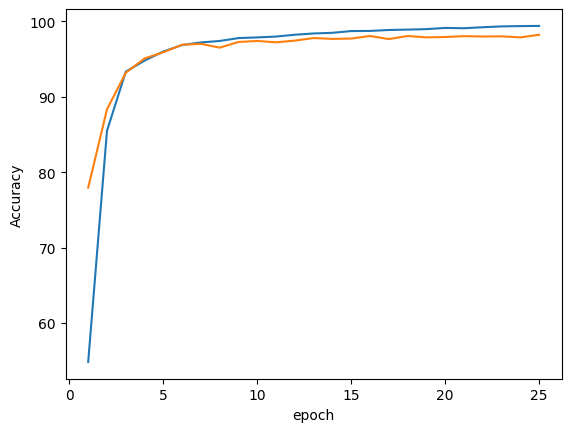

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

In [ ]:
# Save the model
torch.save(model.state_dict(), 'language_detection_model.pth')


In [ ]:
# Create an instance of the model
model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)

# Load the saved model state dict
model.load_state_dict(torch.load('language_detection_model.pth'))
model.eval()  # Set the model to evaluation mode


CharRNNClassifier(
  (embed): Embedding(7188, 64, padding_idx=0)
  (rnn): LSTM(64, 256)
  (h2o): Linear(in_features=256, out_features=22, bias=True)
)

In [ ]:
# Save only the model state dictionary
torch.save(model.state_dict(), 'language_detection_model.pth')


In [ ]:
import torch

# Define the language dictionary class
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

# Function to predict the language of a given text
def predict_language(text, model, char_vocab, lang_vocab, device):
    # Preprocess the input text
    text_indices = [char_vocab.token2idx.get(char, char_vocab.token2idx['<unk>']) for char in text]
    text_tensor = torch.tensor(text_indices, dtype=torch.long, device=device).unsqueeze(1)

    # Forward pass through the model
    with torch.no_grad():
        lengths = torch.tensor([text_tensor.size(0)], dtype=torch.long)
        output = model(text_tensor, lengths)

    # Get the predicted language index
    pred_index = torch.argmax(output).item()

    # Map the index to the language label
    predicted_language = lang_vocab.idx2token[pred_index]
    return predicted_language

# List of languages
languages = [
    'English', 'French', 'Spanish', 'German', 'Italian', 'Portuguese', 'Dutch', 'Russian',
    'Chinese', 'Japanese', 'Korean', 'Arabic', 'Hindi', 'Urdu', 'Bengali', 'Punjabi',
    'Turkish', 'Greek', 'Swedish', 'Norwegian', 'Danish', 'Finnish', 'Polish', 'Czech',
    'Hungarian', 'Romanian', 'Thai', 'Vietnamese', 'Indonesian', 'Malay', 'Filipino',
    'Swahili', 'Dutch', 'Catalan', 'Irish', 'Scottish Gaelic', 'Welsh', 'Basque',
    'Estonian', 'Latvian', 'Lithuanian', 'Slovak', 'Slovenian', 'Serbian', 'Croatian',
    'Bosnian', 'Macedonian', 'Albanian', 'Georgian', 'Armenian', 'Ukrainian', 'Belarusian',
    'Kazakh', 'Uzbek', 'Tamil', 'Telugu', 'Marathi', 'Gujarati', 'Odia', 'Malayalam',
    'Kannada', 'Sinhala', 'Nepali', 'Khmer', 'Lao', 'Burmese', 'Tibetan', 'Dzongkha'
]

# Initialize language vocabulary
lang_vocab = Dictionary()
for lang in languages:
    lang_vocab.add_token(lang)

# Load the trained model
model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
model.load_state_dict(torch.load('/content/language_detection_model.pth'))
model.eval()

# Example usage
text_sample = "Hellow esjf"
predicted_language = predict_language(text_sample, model, char_vocab, lang_vocab, device)
print("Predicted Language:", predicted_language)


Predicted Language: Portuguese
